## 练习

1. 假设我们只想使用时间步$t'$的输入来预测时间步$t > t'$的输出。对于每个时间步，重置门和更新门的最佳值是什么？
1. 调整和分析超参数对运行时间、困惑度和输出顺序的影响。
1. 比较`rnn.RNN`和`rnn.GRU`的不同实现对运行时间、困惑度和输出字符串的影响。
1. 如果仅仅实现门控循环单元的一部分，例如，只有一个重置门或一个更新门会怎样？

perplexity 1.2, 13999.4 tokens/sec on cuda:0
time travellerit s against reason said fre yoeissthe sseith sien
traveller arout im the hermeled the mechanismthen he drew u


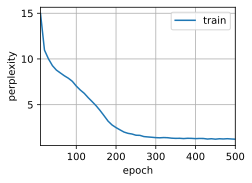

In [1]:
## 练习1
import torch
from torch import nn
from d2l import torch as d2l

# 加载数据
batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

# 获取参数
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    def three():
        return (normal((num_inputs, num_hiddens)),
                normal((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens, device=device))

    W_xz, W_hz, b_z = three()  # 更新门参数
    W_xr, W_hr, b_r = three()  # 重置门参数
    W_xh, W_hh, b_h = three()  # 候选隐状态参数
    W_hq = normal((num_hiddens, num_outputs))  # 输出层参数
    b_q = torch.zeros(num_outputs, device=device)
    params = [W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

# 初始化GRU状态
def init_gru_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )

# 定义GRU模型
def gru(inputs, state, params):
    W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    for X in inputs:
        Z = torch.sigmoid((X @ W_xz) + (H @ W_hz) + b_z) * 0 + 0  # 更新门
        R = torch.sigmoid((X @ W_xr) + (H @ W_hr) + b_r) * 0 + 1  # 重置门
        H_tilda = torch.tanh((X @ W_xh) + ((R * H) @ W_hh) + b_h)
        H = Z * H + (1 - Z) * H_tilda
        Y = H @ W_hq + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

# 设置超参数
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1

# 创建模型并训练
model = d2l.RNNModelScratch(len(vocab), num_hiddens, device, get_params,
                            init_gru_state, gru)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

perplexity 16.6, 17434.8 tokens/sec on cuda:0
time traveller                                                  
traveller                                                  
Learning Rate: 0.01, Hidden Size: 512, Training Time: 283.49 seconds


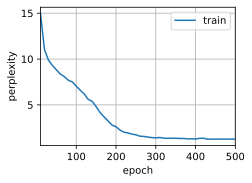

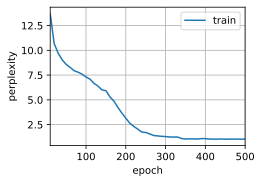

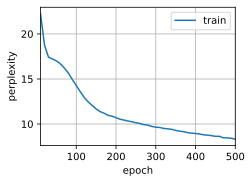

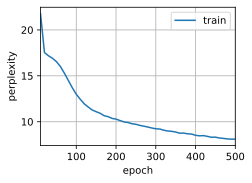

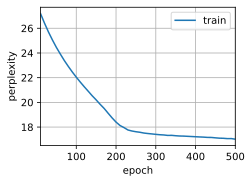

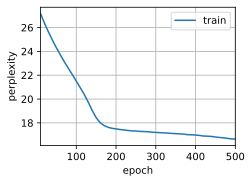

In [2]:
## 练习2
import time

# 设置不同的学习率和隐藏层单元数进行实验
learning_rates = [1, 0.1, 0.01]
hidden_sizes = [256, 512]

for lr in learning_rates:
    for num_hiddens in hidden_sizes:
        # 初始化模型参数
        params = get_params(len(vocab), num_hiddens, device)
        model = d2l.RNNModelScratch(len(vocab), num_hiddens, device, get_params,
                                    init_gru_state, gru)

        # 开始计时
        start_time = time.time()

        # 训练模型
        d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

        # 结束计时
        end_time = time.time()

        print(f"Learning Rate: {lr}, Hidden Size: {num_hiddens}, "
              f"Training Time: {end_time - start_time:.2f} seconds")

AttributeError: module 'd2l.torch' has no attribute 'to_onehot'

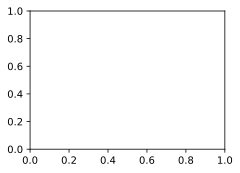

In [3]:
##练习3
import torch
from torch import nn
from d2l import torch as d2l
import time

# 定义使用RNN的模型
class RNNModel(nn.Module):
    def __init__(self, rnn_layer, vocab_size):
        super(RNNModel, self).__init__()
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.dense = nn.Linear(rnn_layer.hidden_size, vocab_size)

    def forward(self, inputs, state):
        X = d2l.to_onehot(inputs.T, self.vocab_size)
        X = torch.stack(X)
        Y, state = self.rnn(X, state)
        # 改变Y的形状
        output = self.dense(Y.view(-1, Y.shape[-1]))
        return output, state

    def begin_state(self, device, batch_size=1):
        return None if isinstance(self.rnn, nn.LSTM) else (torch.zeros((self.rnn.num_layers,
                                                                       batch_size, self.rnn.hidden_size),
                                                                      device=device),)

# 加载数据
batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

# 初始化模型参数
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1

# 使用nn.RNN
rnn_layer = nn.RNN(len(vocab), num_hiddens)
model = RNNModel(rnn_layer, len(vocab)).to(device)
start = time.time()
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)
end = time.time()
print(f'RNN模型训练时间: {end - start:.2f}秒')

# 使用nn.GRU
gru_layer = nn.GRU(len(vocab), num_hiddens)
model = RNNModel(gru_layer, len(vocab)).to(device)
start = time.time()
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)
end = time.time()
print(f'GRU模型训练时间: {end - start:.2f}秒')

perplexity 1.0, 26360.9 tokens/sec on cuda:0
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


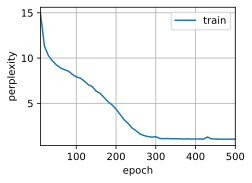

In [4]:
## 练习4

# 只使用重置门的GRU的参数获取函数
def get_params_reset_only(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    W_xr = normal((num_inputs, num_hiddens))
    W_hr = normal((num_hiddens, num_hiddens))
    b_r = torch.zeros(num_hiddens, device=device)

    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)

    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)

    params = [W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

def gru_reset_only(inputs, state, params):
    W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    for X in inputs:
        R = torch.sigmoid((X @ W_xr) + (H @ W_hr) + b_r)
        H_tilda = torch.tanh((X @ W_xh) + ((R * H) @ W_hh) + b_h)
        H = H_tilda
        Y = H @ W_hq + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

# 设置超参数
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1

# 获取参数
params = get_params_reset_only(vocab_size, num_hiddens, device)

# 创建并训练模型
model = d2l.RNNModelScratch(len(vocab), num_hiddens, device, get_params_reset_only,
                            init_gru_state, gru_reset_only)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)